<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/changdaeoh/HandsOn_DL/blob/main/ch14_CNN_for_CV_part1.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('seaborn-darkgrid')

## Convolutional layer

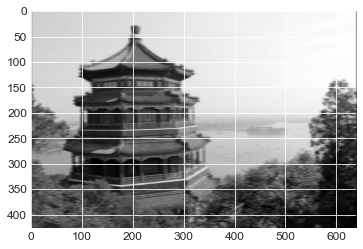

In [8]:
# !pip install Pillow
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
# 흐르는 데이터는 (미니배치크기, 높이, 너비, 채널 수) 4차원 텐서
batch_size, height, width, channels = images.shape

# 필터 2개 만들기
# 3차원 필터[행,열,채널]가 2개  => 4차원 텐서로 정의할 수 있음
filters = np.zeros(shape = (7, 7, channels, 2), dtype = np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides = 1, padding = "SAME")

plt.imshow(outputs[0,:,:,1], cmap = "gray") # 첫 번째 이미지의 두 번째 특성맵 시각화
plt.show()

필터를 직접 지정하는 경우는 거의없음.  
실제 CNN에서는 훈련 가능한 변수로 필터를 정의  
keras.layers.Conv2D층 사용하기

In [6]:
conv = keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1,
                           padding = "same", activation = "relu")

## Pooling layer

In [ ]:
# 2*2 커널을 이용하는 max pooling 층 (stride는 디폴트로 커널크기와 같음)
max_pool = keras.layers.MaxPool2D(pool_size = 2)

# depthwise pooling (깊이방향의로 pooling 수행하기)
# 깊이방향 풀링층을 사용하기 위해선 텐서플로 저수준 딥러닝 api - nn.max_pool 함수를 사용
output = tf.nn.max_pool(images,
                        ksize = (1,1,1,3), # 미니배치, 높이, 너비, 깊이(channel)
                        strides = (1,1,1,3),
                        padding = "valid")
# 케라스 모델의 층으로 사용하기 위해서는 Lambda 층으로 감싸줘야함.
depth_pool = keras.layers.Lambda(
    lambda X : tf.nn.max_pool(X, ksize = (1,1,1,3),
                              strides = (1,1,1,3), padding = "valid"))

# global average pooling layer
global_avg_pool_1 = keras.layers.GlobalAvgPool2D()
global_avg_pool_2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis = [1,2]))

# ordinary CNN for Fashion MNIST

* 10개의 클래스 레이블이 있음
* 7만개의 샘플 - 6만 : train, 1만 : test
* 해상도 28*28
* 픽셀값 0 ~ 255

#### data loading

In [43]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [44]:
# standardization (min-max scaling으로 대체 가능)
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# 합성곱 층이 기대하는 shape로 맟춰주기 [batch, row, col, channel]
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [24]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

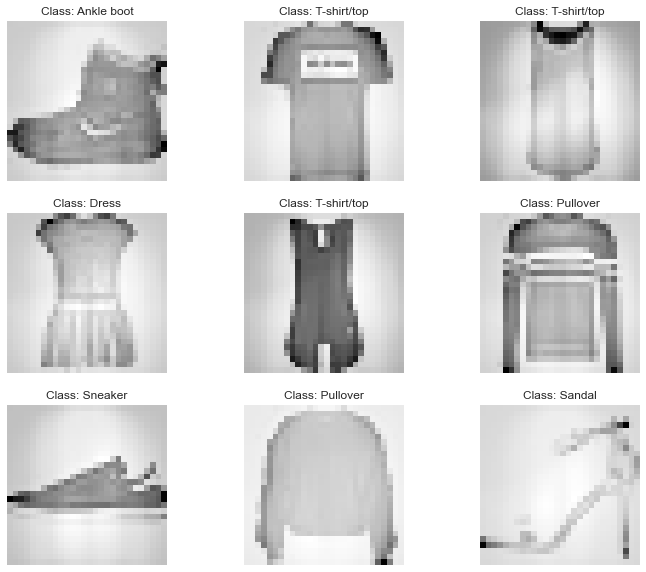

In [40]:
# 이미지 샘플
plt.figure(figsize=(12, 10))
index = 0
for image, label in zip(X_train[:9], y_train[:9]):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show()

#### base model

In [45]:
# 전형적인 cnn 구조
model = keras.models.Sequential([
    # 첫 합성곱층에서는 큰 필터(7*7) 사용. 이후 층들에서는 3*3 사용
    keras.layers.Conv2D(filters = 64, kernel_size = 7, activation = "relu", 
                        padding = "same", input_shape = [28,28,1]),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Conv2D(128,3, activation='relu', padding="SAME"),
    keras.layers.Conv2D(128,3, activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Conv2D(256,3, activation='relu', padding="SAME"),
    keras.layers.Conv2D(256,3, activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size = 2),
    # Fully Connected Layers
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation = "softmax")
])

In [ ]:
# 모델 컴파일, 피팅
model.compile(optimizer = "nadam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

model.fit(X_train, y_train, epochs = 10, validation_data = (X_valid, y_valid))

In [50]:
# 전체 train셋으로 다시 피팅
X_train_full = (X_train_full - X_mean) / X_std
X_train_full = X_train_full[..., np.newaxis]

model.fit(X_train_full, y_train_full, epochs = 10)

In [ ]:
# 평가 및 예측
score = model.evaluate(X_test, y_test)

X_new = X_test[:10]
y_pred = model.predict(X_new)
predictions = [np.argmax(i) for i in y_pred]
print(predictions)
pred_labels = [class_names[i] for i in predictions]
print(pred_labels)